In [1]:
import uproot
import glob
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import gridspec
from matplotlib import colors
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# 1. Utilities

## 1.1 Making a table from a 2D hist

In [2]:
def table_from_hist2D(bin_values, x_bin_edges, y_bin_edges, name="", outfile=None, 
                      x_name="x", y_name="y", writemode="w"):
    if not name:
        name = "tabularHist2D"
    cpp = "\nfloat "+name+"(float %s, float %s) {\n" % (x_name, y_name)
    for i in range(bin_values.shape[1]):
        for j in range(bin_values.shape[0]):
            edges = []
            # Low x bin
            edges.append("{0} >= {1:.3f}".format(x_name, x_bin_edges[i]))
            if i < bin_values.shape[1]-1:
                # High x bin
                edges.append("{0} < {1:.3f}".format(x_name, x_bin_edges[i+1]))
            if j < bin_values.shape[0]:
                # Low y bin
                edges.append("{0} >= {1:.3f}".format(y_name, y_bin_edges[j]))            
                # High y bin
                edges.append("{0} < {1:.3f}".format(y_name, y_bin_edges[j+1]))
            # Add if statement
            cpp += "    if ({0}) return {1:0.3f};\n".format(" && ".join(edges), bin_values[j,i])
    # Add default return
    cpp += "    return 0.0;\n"
    # Wrap up function      
    cpp += "}\n"
    # Print code
    print(cpp)
    # Write code
    if outfile:
        with open(outfile, writemode) as fout:
            fout.write(cpp)
            
    return

## 1.2 Bin text for 2D histograms

In [3]:
def compute_darkness(r, g, b, a=1.0):
    """Compute the 'darkness' value from RGBA (darkness = 1 - luminance)
       stolen from Nick Amin: https://github.com/aminnj/yahist
    """
    return a * (1.0 - (0.299 * r + 0.587 * g + 0.114 * b))

def bin_text(counts, x_edges, y_edges, axes, cbar, size=8, fmt=":g"):
    """Write bin population on top of 2D histogram bins,
       stolen from Nick Amin: https://github.com/aminnj/yahist
    """
    
    x_centers = x_edges[1:]-(x_edges[1:]-x_edges[:-1])/2
    y_centers = y_edges[1:]-(y_edges[1:]-y_edges[:-1])/2

    xyz = np.c_[        
        np.tile(x_centers, len(y_centers)),
        np.repeat(y_centers, len(x_centers)),
        counts.flatten(),
    ][counts.flatten() != 0]

    r, g, b, a = cbar.mappable.to_rgba(xyz[:, 2]).T
    colors = np.zeros((len(xyz), 3))
    colors[compute_darkness(r, g, b, a) > 0.45] = 1

    for (x, y, z), color in zip(xyz, colors):
        axes.text(
            x,
            y,
            ("{"+fmt+"}").format(z),
            color=color,
            ha="center",
            va="center",
            fontsize=size,
            wrap=True,
        )

    return

## 1.3 Plot 2D histogram from uproot

In [4]:
def plot_TH2D(uproot_TH2D):
    # Extract info from TH2D
    values, bins = uproot_TH2D.numpy()
    xbins, ybins = bins[0]
    # Figure
    fig = plt.figure(figsize=(7*1.75,8*1.75))
    axes = plt.subplot(111)
    # Plot
    c = axes.pcolorfast(xbins, ybins, values.T);
    cbar = fig.colorbar(c, ax=axes);
    # Formatting
    plt.xticks(np.round(xbins, decimals=1));
    plt.yticks(ybins);
    bin_text(values.T, xbins, ybins, axes, cbar, size=8, fmt=":.3g")
    return values.T, xbins, ybins

# 2. Making tables

## 2.1 Electron ID scale factors

In [5]:
el_sfs_tfile = uproot.open("/hadoop/cms/store/user/jguiang/ttbarCR/scalefactors/Run2016_ID-tight_electrons.root")
el_sfs_tfile.items()

[('EGamma_SF2D;1', <TH2F 'h2_scaleFactorsEGamma' 0x7fed418ae6d8>),
 ('EGamma_EffData2D;1', <TH2F 'h2_scaleFactorsEGamma' 0x7fed418ae940>),
 ('EGamma_EffMC2D;1', <TH2F 'h2_scaleFactorsEGamma' 0x7fed418aeba8>),
 ('grSF1D_0;1', <TGraphErrors 'Graph5' 0x7fed418c9090>),
 ('grSF1D_1;1', <TGraphErrors 'Graph0' 0x7fed418c9190>),
 ('grSF1D_2;1', <TGraphErrors 'Graph1' 0x7fed418c9290>),
 ('grSF1D_3;1', <TGraphErrors 'Graph2' 0x7fed418c9390>),
 ('grSF1D_4;1', <TGraphErrors 'Graph3' 0x7fed418c9490>),
 ('grSF1D_5;1', <TGraphErrors 'Graph4' 0x7fed418c9590>)]

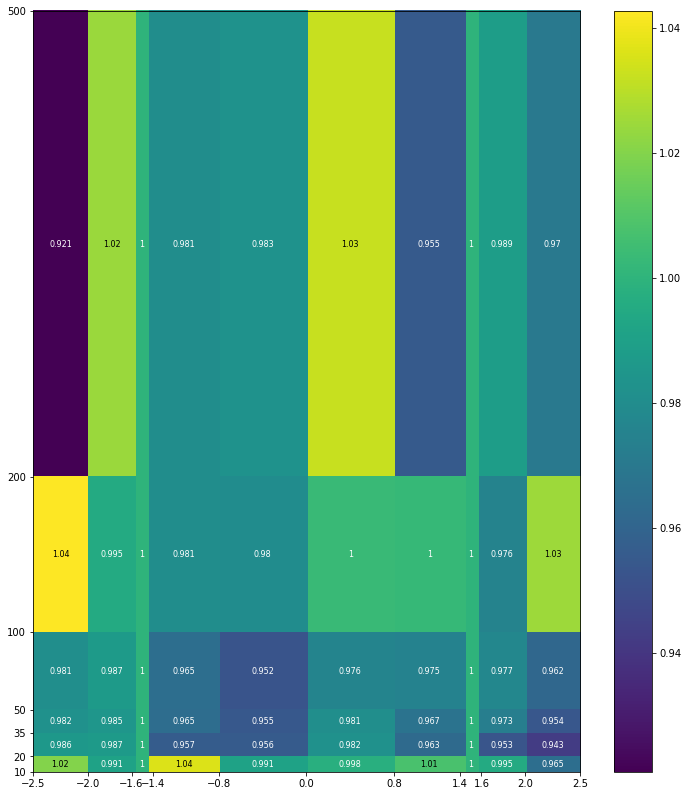

In [6]:
el_sfs_TH2D = el_sfs_tfile.get("EGamma_SF2D")
el_sfs_values, el_sfs_xbins, el_sfs_ybins = plot_TH2D(el_sfs_TH2D)

In [7]:
table_from_hist2D(
    el_sfs_values.T, 
    el_sfs_ybins, 
    el_sfs_xbins, 
    name="elecIDScaleFactors", 
    x_name="pt", 
    y_name="eta",
    outfile="scalefactors.C",
    writemode="w"
)


float elecIDScaleFactors(float pt, float eta) {
    if (pt >= 10.000 && pt < 20.000 && eta >= -2.500 && eta < -2.000) return 1.020;
    if (pt >= 10.000 && pt < 20.000 && eta >= -2.000 && eta < -1.566) return 0.991;
    if (pt >= 10.000 && pt < 20.000 && eta >= -1.566 && eta < -1.444) return 1.000;
    if (pt >= 10.000 && pt < 20.000 && eta >= -1.444 && eta < -0.800) return 1.036;
    if (pt >= 10.000 && pt < 20.000 && eta >= -0.800 && eta < 0.000) return 0.991;
    if (pt >= 10.000 && pt < 20.000 && eta >= 0.000 && eta < 0.800) return 0.998;
    if (pt >= 10.000 && pt < 20.000 && eta >= 0.800 && eta < 1.444) return 1.008;
    if (pt >= 10.000 && pt < 20.000 && eta >= 1.444 && eta < 1.566) return 1.000;
    if (pt >= 10.000 && pt < 20.000 && eta >= 1.566 && eta < 2.000) return 0.995;
    if (pt >= 10.000 && pt < 20.000 && eta >= 2.000 && eta < 2.500) return 0.965;
    if (pt >= 20.000 && pt < 35.000 && eta >= -2.500 && eta < -2.000) return 0.986;
    if (pt >= 20.000 && pt < 35.000 &&

## 2.2 Muon ID scale factors

In [8]:
mu_id_sfs_tfile = uproot.open("/hadoop/cms/store/user/jguiang/ttbarCR/scalefactors/Run2016G-H_ID_sf_muons.root")
mu_id_sfs_tfile.items()

[('NUM_LooseID_DEN_genTracks_eta_pt;1',
  <TH2D 'NUM_LooseID_DEN_genTracks_eta_pt' 0x7fed3f3b6fc8>),
 ('NUM_HighPtID_DEN_genTracks_eta_pair_newTuneP_probe_pt;1',
  <TH2D 'NUM_HighPtID_DEN_genTracks_eta_pair_newTuneP_probe_pt' 0x7fed3f3bb368>),
 ('NUM_TightID_DEN_genTracks_eta_pt;1',
  <TH2D 'NUM_TightID_DEN_genTracks_eta_pt' 0x7fed3f3bb5d0>),
 ('NUM_MediumID_DEN_genTracks_eta_pt;1',
  <TH2D 'NUM_MediumID_DEN_genTracks_eta_pt' 0x7fed3f3bb838>)]

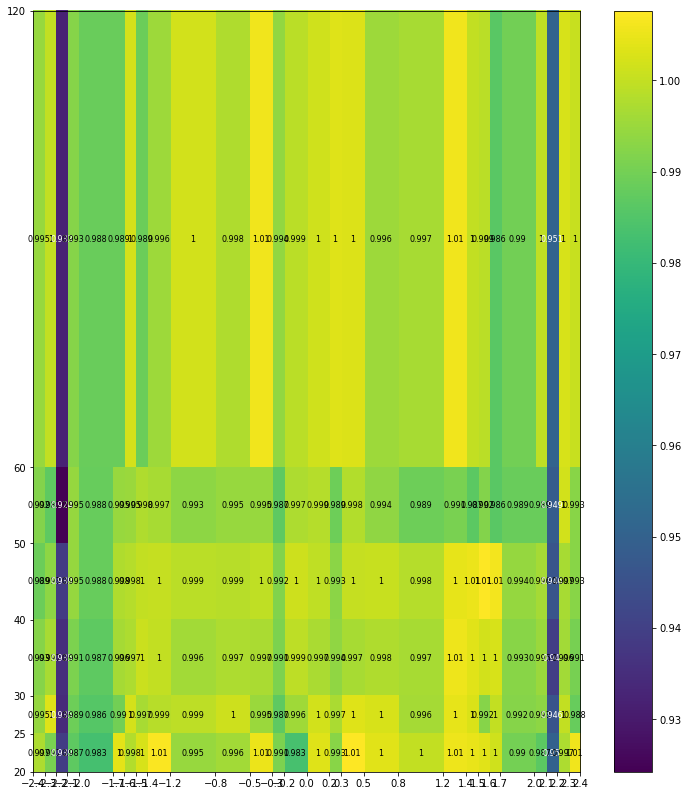

In [9]:
mu_id_sfs_TH2D = mu_id_sfs_tfile.get("NUM_MediumID_DEN_genTracks_eta_pt")
mu_id_sfs_values, mu_id_sfs_xbins, mu_id_sfs_ybins = plot_TH2D(mu_id_sfs_TH2D)

In [10]:
table_from_hist2D(
    mu_id_sfs_values.T, 
    mu_id_sfs_ybins, 
    mu_id_sfs_xbins, 
    name="muonMediumIDScaleFactors", 
    x_name="pt", 
    y_name="eta",
    outfile="scalefactors.C",
    writemode="a"
)


float muonMediumIDScaleFactors(float pt, float eta) {
    if (pt >= 20.000 && pt < 25.000 && eta >= -2.400 && eta < -2.300) return 0.997;
    if (pt >= 20.000 && pt < 25.000 && eta >= -2.300 && eta < -2.200) return 0.991;
    if (pt >= 20.000 && pt < 25.000 && eta >= -2.200 && eta < -2.100) return 0.939;
    if (pt >= 20.000 && pt < 25.000 && eta >= -2.100 && eta < -2.000) return 0.987;
    if (pt >= 20.000 && pt < 25.000 && eta >= -2.000 && eta < -1.700) return 0.983;
    if (pt >= 20.000 && pt < 25.000 && eta >= -1.700 && eta < -1.600) return 1.004;
    if (pt >= 20.000 && pt < 25.000 && eta >= -1.600 && eta < -1.500) return 0.998;
    if (pt >= 20.000 && pt < 25.000 && eta >= -1.500 && eta < -1.400) return 1.002;
    if (pt >= 20.000 && pt < 25.000 && eta >= -1.400 && eta < -1.200) return 1.007;
    if (pt >= 20.000 && pt < 25.000 && eta >= -1.200 && eta < -0.800) return 0.995;
    if (pt >= 20.000 && pt < 25.000 && eta >= -0.800 && eta < -0.500) return 0.996;
    if (pt >= 20.000 

## 2.3 Muon iso scale factors

In [11]:
mu_iso_sfs_tfile = uproot.open("/hadoop/cms/store/user/jguiang/ttbarCR/scalefactors/Run2016G-H_ISO_sf_muons.root")
mu_iso_sfs_tfile.items()

[('NUM_LooseRelTkIso_DEN_HighPtIDandIPCut_eta_pair_newTuneP_probe_pt;1',
  <TH2D 'NUM_LooseRelTkIso_DEN_HighPtIDandIPCut_eta_pair_newTuneP_probe_pt' 0x7fed3f4da4c8>),
 ('NUM_TightRelIso_DEN_MediumID_eta_pt;1',
  <TH2D 'NUM_TightRelIso_DEN_MediumID_eta_pt' 0x7fed3f4da838>),
 ('NUM_TightRelIso_DEN_TightIDandIPCut_eta_pt;1',
  <TH2D 'NUM_TightRelIso_DEN_TightIDandIPCut_eta_pt' 0x7fed3f4daaa0>),
 ('NUM_LooseRelIso_DEN_MediumID_eta_pt;1',
  <TH2D 'NUM_LooseRelIso_DEN_MediumID_eta_pt' 0x7fed3f4dad60>),
 ('NUM_LooseRelIso_DEN_LooseID_eta_pt;1',
  <TH2D 'NUM_LooseRelIso_DEN_LooseID_eta_pt' 0x7fed3f4dafc8>),
 ('NUM_LooseRelIso_DEN_TightIDandIPCut_eta_pt;1',
  <TH2D 'NUM_LooseRelIso_DEN_TightIDandIPCut_eta_pt' 0x7fed3f487260>)]

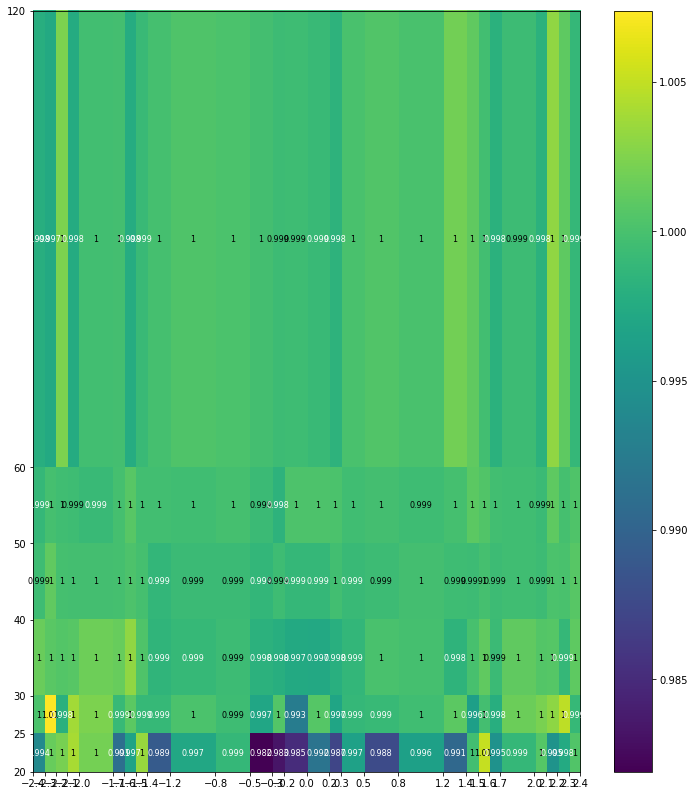

In [12]:
mu_iso_sfs_TH2D = mu_iso_sfs_tfile.get("NUM_LooseRelIso_DEN_MediumID_eta_pt")
mu_iso_sfs_values, mu_iso_sfs_xbins, mu_iso_sfs_ybins = plot_TH2D(mu_iso_sfs_TH2D)

In [13]:
table_from_hist2D(
    mu_iso_sfs_values.T, 
    mu_iso_sfs_ybins, 
    mu_iso_sfs_xbins, 
    name="muonLooseIsoMediumIDScaleFactors", 
    x_name="pt", 
    y_name="eta",
    outfile="scalefactors.C",
    writemode="a"
)


float muonLooseIsoMediumIDScaleFactors(float pt, float eta) {
    if (pt >= 20.000 && pt < 25.000 && eta >= -2.400 && eta < -2.300) return 0.994;
    if (pt >= 20.000 && pt < 25.000 && eta >= -2.300 && eta < -2.200) return 1.001;
    if (pt >= 20.000 && pt < 25.000 && eta >= -2.200 && eta < -2.100) return 1.002;
    if (pt >= 20.000 && pt < 25.000 && eta >= -2.100 && eta < -2.000) return 1.004;
    if (pt >= 20.000 && pt < 25.000 && eta >= -2.000 && eta < -1.700) return 1.002;
    if (pt >= 20.000 && pt < 25.000 && eta >= -1.700 && eta < -1.600) return 0.991;
    if (pt >= 20.000 && pt < 25.000 && eta >= -1.600 && eta < -1.500) return 0.997;
    if (pt >= 20.000 && pt < 25.000 && eta >= -1.500 && eta < -1.400) return 1.003;
    if (pt >= 20.000 && pt < 25.000 && eta >= -1.400 && eta < -1.200) return 0.989;
    if (pt >= 20.000 && pt < 25.000 && eta >= -1.200 && eta < -0.800) return 0.997;
    if (pt >= 20.000 && pt < 25.000 && eta >= -0.800 && eta < -0.500) return 0.999;
    if (pt >=

## 2.4 Electron reconstruction scale factors

In [14]:
el_reco_sfs_tfile = uproot.open(
    "/hadoop/cms/store/user/jguiang/ttbarCR/scalefactors/Run2016_reco-eff_pt-geq-20GeV_electrons.root"
)
el_reco_sfs_tfile.items()

[('EGamma_SF2D;1', <TH2F 'h2_scaleFactorsEGamma' 0x7fed3f492ba8>),
 ('EGamma_EffData2D;1', <TH2F 'h2_scaleFactorsEGamma' 0x7fed3f492ec0>),
 ('EGamma_EffMC2D;1', <TH2F 'h2_scaleFactorsEGamma' 0x7fed3f80c158>),
 ('grSF1D_0;1', <TGraphErrors 'Graph' 0x7fed3f732750>),
 ('grSF1D_1;1', <TGraphErrors 'Graph' 0x7fed3f732650>),
 ('grSF1D_2;1', <TGraphErrors 'Graph' 0x7fed3f732610>),
 ('grSF1D_3;1', <TGraphErrors 'Graph' 0x7fed418ea810>)]

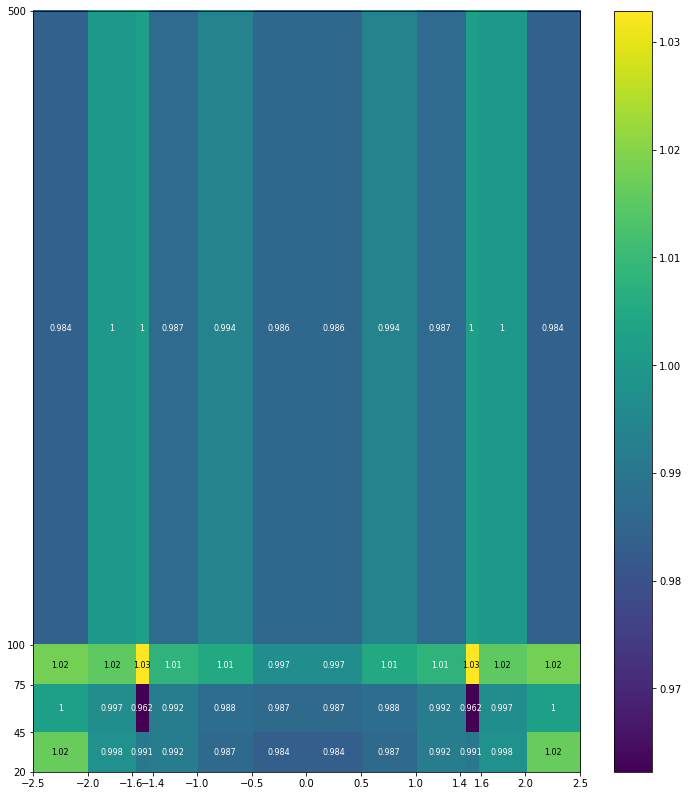

In [15]:
el_reco_sfs_TH2D = el_reco_sfs_tfile.get("EGamma_SF2D")
el_reco_sfs_values, el_reco_sfs_xbins, el_reco_sfs_ybins = plot_TH2D(el_reco_sfs_TH2D)

In [16]:
table_from_hist2D(
    el_reco_sfs_values.T, 
    el_reco_sfs_ybins, 
    el_reco_sfs_xbins, 
    name="elecRecoScaleFactors", 
    x_name="pt", 
    y_name="eta",
    outfile="scalefactors.C",
    writemode="a"
)


float elecRecoScaleFactors(float pt, float eta) {
    if (pt >= 20.000 && pt < 45.000 && eta >= -2.500 && eta < -2.000) return 1.016;
    if (pt >= 20.000 && pt < 45.000 && eta >= -2.000 && eta < -1.566) return 0.998;
    if (pt >= 20.000 && pt < 45.000 && eta >= -1.566 && eta < -1.444) return 0.991;
    if (pt >= 20.000 && pt < 45.000 && eta >= -1.444 && eta < -1.000) return 0.992;
    if (pt >= 20.000 && pt < 45.000 && eta >= -1.000 && eta < -0.500) return 0.987;
    if (pt >= 20.000 && pt < 45.000 && eta >= -0.500 && eta < 0.000) return 0.984;
    if (pt >= 20.000 && pt < 45.000 && eta >= 0.000 && eta < 0.500) return 0.984;
    if (pt >= 20.000 && pt < 45.000 && eta >= 0.500 && eta < 1.000) return 0.987;
    if (pt >= 20.000 && pt < 45.000 && eta >= 1.000 && eta < 1.444) return 0.992;
    if (pt >= 20.000 && pt < 45.000 && eta >= 1.444 && eta < 1.566) return 0.991;
    if (pt >= 20.000 && pt < 45.000 && eta >= 1.566 && eta < 2.000) return 0.998;
    if (pt >= 20.000 && pt < 45.000 